この課題では、
人工知能に関する断創録
http://aidiary.hatenablog.com/entry/20170108/1483876657

Kerasによる、ものすごくシンプルな画像分類
http://qiita.com/hiroeorz@github/items/ecb39ed4042ebdc0a957
を参考にした


In [2]:
import os
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import optimizers
import numpy as np
from PIL import Image
import os
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical

Using TensorFlow backend.


In [3]:
img_width, img_height = 150, 150
train_data_dir = '/home/yanai-lab/sugiya-y/space/study/keras/repo4/data/train'
validation_data_dir = '/home/yanai-lab/sugiya-y/space/study/keras/repo4/data/validation'
nb_train_samples = 2000
nb_validation_samples = 800
nb_epoch = 20

In [4]:
result_dir = '/home/yanai-lab/sugiya-y/space/study/keras/repo4/results'

In [5]:
def save_history(history, result_file):
    loss = history.history['loss']
    acc = history.history['acc']
    val_loss = history.history['val_loss']
    val_acc = history.history['val_acc']
    nb_epoch = len(acc)

    with open(result_file, "w") as fp:
        fp.write("epoch\tloss\tacc\tval_loss\tval_acc\n")
        for i in range(nb_epoch):
            fp.write("%d\t%f\t%f\t%f\t%f\n" % (i, loss[i], acc[i], val_loss[i], val_acc[i]))

In [33]:
train_image = []
train_label = []
val_image = []
val_label = []

# ./data/train 以下のcat,dogディレクトリ以下の画像を読み込む。
for dir in os.listdir("/home/yanai-lab/sugiya-y/space/study/keras/repo4/data/train"):
    if dir == ".DS_Store":
        continue

    dir1 = "/home/yanai-lab/sugiya-y/space/study/keras/repo4/data/train/" + dir 
    label = 0

    if dir == "cats":
        label = 0
    elif dir == "dogs":
        label = 1

    for file in os.listdir(dir1):
        if file != ".DS_Store":
            train_label.append(label)
            filepath = dir1 + "/" + file
           
            image = np.array(Image.open(filepath).resize((150, 150)))
            image = image.astype("float32")
            # 出来上がった配列をimage_listに追加。
            train_image.append(image / 255.)

# kerasに渡すためにnumpy配列に変換。
train_image = np.array(train_image)

Y_train = to_categorical(train_label)
print(train_image.shape)

(2000, 150, 150, 3)


In [34]:
# ./data/train 以下のcat,dogディレクトリ以下の画像を読み込む。
for dir in os.listdir("/home/yanai-lab/sugiya-y/space/study/keras/repo4/data/validation"):
    if dir == ".DS_Store":
        continue

    dir1 = "/home/yanai-lab/sugiya-y/space/study/keras/repo4/data/validation/" + dir 
    label = 0

    if dir == "cats":
        label = 0
    elif dir == "dogs":
        label = 1

    for file in os.listdir(dir1):
        if file != ".DS_Store":
            val_label.append(label)
            filepath = dir1 + "/" + file
           
            image = np.array(Image.open(filepath).resize((150, 150)))
            image = image.astype("float32")
            # 出来上がった配列をimage_listに追加。
            val_image.append(image / 255.)

# kerasに渡すためにnumpy配列に変換。
val_image = np.array(val_image)

Y_val = to_categorical(val_label)
print(val_image.shape)

(800, 150, 150, 3)


In [23]:
model = VGG16(include_top=False, weights='imagenet', input_shape=(150,150,3))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [35]:
bottleneck_features_train = model.predict(train_image)
bottleneck_features_validation = model.predict(val_image)

In [36]:
print(bottleneck_features_train.shape)
print(bottleneck_features_validation.shape)

(2000, 4, 4, 512)
(800, 4, 4, 512)


In [38]:
result_dir = '/home/yanai-lab/sugiya-y/space/study/keras/repo4/results'
np.save(os.path.join(result_dir, 'bottleneck_features_train.npy'),
            bottleneck_features_train)
np.save(os.path.join(result_dir, 'bottleneck_features_validation.npy'),
            bottleneck_features_validation)

In [39]:
my_model = Sequential()
my_model.add(Flatten(input_shape=bottleneck_features_train.shape[1:]))
my_model.add(Dense(256))
my_model.add(Activation('relu'))
my_model.add(Dropout(0.5))
my_model.add(Dense(2))
my_model.add(Activation('softmax'))

my_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               2097408   
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 514       
_________________________________________________________________
activation_2 (Activation)    (None, 2)                 0         
Total params: 2,097,922
Trainable params: 2,097,922
Non-trainable params: 0
_________________________________________________________________


In [41]:
my_model.compile(loss='binary_crossentropy',optimizer=Adam(),metrics=['accuracy'])

In [43]:
batch_size = 32
epochs = 20
history = my_model.fit(bottleneck_features_train,Y_train,batch_size=batch_size,
                      epochs=epochs,
                      validation_split=0.1,
                      verbose=2)

Train on 1800 samples, validate on 200 samples
Epoch 1/20
0s - loss: 0.4887 - acc: 0.8006 - val_loss: 0.7523 - val_acc: 0.6050
Epoch 2/20
0s - loss: 0.2583 - acc: 0.8878 - val_loss: 0.1612 - val_acc: 0.9450
Epoch 3/20
0s - loss: 0.1973 - acc: 0.9178 - val_loss: 0.3428 - val_acc: 0.8400
Epoch 4/20
0s - loss: 0.1452 - acc: 0.9422 - val_loss: 0.2412 - val_acc: 0.9150
Epoch 5/20
0s - loss: 0.1343 - acc: 0.9511 - val_loss: 0.3258 - val_acc: 0.8550
Epoch 6/20
0s - loss: 0.1061 - acc: 0.9589 - val_loss: 0.2659 - val_acc: 0.9000
Epoch 7/20
0s - loss: 0.0791 - acc: 0.9711 - val_loss: 0.2237 - val_acc: 0.9200
Epoch 8/20
0s - loss: 0.0689 - acc: 0.9772 - val_loss: 0.3083 - val_acc: 0.8600
Epoch 9/20
0s - loss: 0.0645 - acc: 0.9772 - val_loss: 0.6362 - val_acc: 0.7600
Epoch 10/20
0s - loss: 0.0702 - acc: 0.9761 - val_loss: 0.1815 - val_acc: 0.9350
Epoch 11/20
0s - loss: 0.0522 - acc: 0.9800 - val_loss: 0.5044 - val_acc: 0.8100
Epoch 12/20
0s - loss: 0.0540 - acc: 0.9839 - val_loss: 0.6782 - val_ac

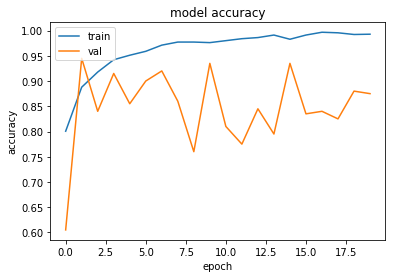

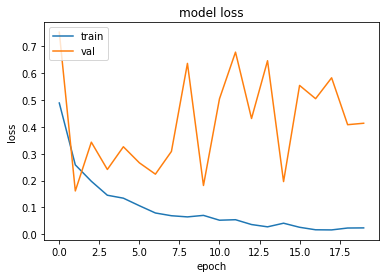

In [45]:
%matplotlib inline
import matplotlib.pyplot as plt


plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [49]:
model.save_weights(os.path.join(result_dir, 'bottleneck_fc_model.h5'))
save_history(history, os.path.join(result_dir, 'history_extractor.txt'))


　CNNをスクラッチで作成した時と比べて、飛躍的に精度が向上したことが明らかに分かった。
 また、学習にかかった時間も、CNNの時と比べて早かった。ただし、これにに関しては少し疑問が残っていて、
 Generator関数を使用した際に動作が遅くなってしまう、ということが考えられる。これを今回は使用していないために、高速に動作した、ということも考えられる。
　原因としては、GeneratorはGPUで動作せずにCPU駆動である、Generatorは行列を無限に生成するために無駄なメモリを使用していた、などを考えている。
　実装に必須な関数ではなく、コードを簡潔に書くためだけの関数なので、これを使用することで動作が遅くなるのであれば、現環境では使用しないことが賢い選択といえると考える。